In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import torch

In [36]:
df = pd.read_csv(r"../data/processed/tweets_label.csv")

In [37]:
df.head()

,date,username,content_clean,content_translated,sentiment
0,2023-04-08 15:01:24+00:00,txtdrakuntansi,dr piutang thr dr piutang gaji cr pendapatan j...,from the receivables of the THR receivables fr...,neutral
1,2023-04-08 14:52:40+00:00,gummypark61,sedikit curhat bahkan pas korona aja pernah ma...,a little vent even when corona just entered fu...,neutral
2,2023-04-08 14:45:03+00:00,yufada_,rep dibawah sini yg mau spay thr receh 1000 un...,Rep below are those who want to spay THR DREH ...,negative
3,2023-04-08 13:39:44+00:00,mindaart,selamat kepada pemenang ga thr masing2 100 spa...,Congratulations to the winner of GA THR each 1...,positive
4,2023-04-08 12:51:00+00:00,haelovelychan,ak supres pake link thr sama daget yh yg ke 4,A suppress packed link,neutral


In [38]:
import re
import string
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import emoji


# Remove stopwords and stem the tokens
stop_words = set(nltk.corpus.stopwords.words('indonesian'))
# Define additional stopwords for Indonesian (gaul)
additional_stopwords = [
    'aq', 'siol', 'japri', 'wot', 'bpp', 'aniyay', 'bodoamat',
    'pepes', 'tauhid', 'oleng', 'rsck', 'kakap', 'tot', 'pel', 'chap',
    'gur', 'bgd', 'tsiap', 'tasep', 'bucin', 'joged', 'smule',
    'skuyy', 'lul', 'tokek', 'gerbek', 'glondong', 'bambank', 'srikandi',
    'ceuki', 'mabar', 'ketringan', 'rumpi', 'ungkit', 'ngenes',
    'bujuh', 'woles', 'geboy', 'aja', 'ak', 'aku', 'alay', 'apaan', 'asli', 'asyik', 'bahagia', 'banget', 'berarti',
    'best', 'biasa', 'bodo', 'boleh', 'canda', 'capek', 'ceile', 'cihui', 'cit', 'coy',
    'curcol', 'dan', 'daripada', 'dekil', 'dikit-dikit', 'dong', 'duh', 'eh', 'eits', 
    'enak', 'fotogenik', 'gadungan', 'gaul', 'gayeng', 'geer', 'gelap', 'gemes', 'gendut', 
    'gila', 'gilak', 'gini', 'gitu-gitu', 'gue', 'gyu', 'hai', 'halah', 'he', 'hebat', 
    'hee', 'hehe', 'ho', 'ih', 'iya', 'jangan', 'jelek', 'jiji', 'joget', 'juga', 
    'jumat', 'jutek', 'kasihan', 'kecewa', 'kepo', 'ketawa', 'kocak', 'kok', 'konyol', 'koplak', 
    'kriuk', 'kulit jeruk', 'kunyuk', 'lebay', 'lmao', 'lol', 'mahal', 'mana', 'mantap', 'matre', 
    'mbledos', 'muka tembok', 'ngeh', 'ngeri', 'nggak', 'ngilu', 'ngocol', 'nyebelin', 'nyerah', 'nyesel', 
    'oke', 'omg', 'oneng', 'pake', 'pantesan', 'parah', 'pengen', 'petjah', 'polos', 'promosi', 
    'puas', 'rame', 'rapopo', 'rempong', 'sabar', 'sedih', 'sehati', 'seru', 'sih', 'sindir', 'jg', 'ya',
    'yg', 'guys', 'kalo', 'dpt', 'bssh', 'dah', 'menyepong', 'krn']

stop_words.update(additional_stopwords)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_tweet(tweet):
    # Remove URLs, mentions, hashtags
    tweet = re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#\w+', '', tweet)

    #demoji
    tweet = emoji.demojize(tweet)

    #thr
    tweet = re.sub(r'\bthr\b', '', tweet)

    #gak
    tweet = re.sub(r'\bga\b', 'gak', tweet)

    # Tokenize the tweet
    tweet_tokens = nltk.word_tokenize(tweet)

    cleaned_tokens = []
    for token in tweet_tokens:
        if token not in stop_words:
            stemmed_token = stemmer.stem(token)
            cleaned_tokens.append(stemmed_token)

    # Join the cleaned tokens
    cleaned_tweet = ' '.join(cleaned_tokens)

    # Menghapus kata-kata dengan panjang kurang dari 1 karakter namun angka masih masuk
    cleaned_tweet = " ".join(word for word in cleaned_tweet.split() if (len(word) > 2 or word.isdigit()))

    return cleaned_tweet


In [39]:
df['content_inference'] = df['content_clean'].apply(clean_tweet)

In [40]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("fathan/ijelid-indobertweet")
model = AutoModel.from_pretrained("fathan/ijelid-indobertweet")


Some weights of the model checkpoint at fathan/ijelid-indobertweet were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at fathan/ijelid-indobertweet and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
max_length = 0
for content in df['content_inference']:
    length = len(content)
    if length > max_length:
        max_length = length

print("Panjang maksimum: ", max_length)

Panjang maksimum:  318


In [42]:
# Tokenize sentences using BERT tokenizer
encoded_dict = tokenizer(df['content_inference'].tolist(), 
                          add_special_tokens=True,
                          padding=True,
                          truncation=True,
                          max_length=max_length,
                          return_tensors='pt')  # change 'np' to 'pt'
input_ids = encoded_dict["input_ids"]
attention_mask = encoded_dict["attention_mask"]

# Generate embeddings for sentences using BERT model
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    features = last_hidden_states[0][:,0,:].numpy()

df['features_content_inference'] = list(features)

#simpan feature
df.to_csv(r"../data/processed/feature_tweets_label.csv")


In [43]:
#import kmeans
from sklearn.cluster import KMeans


# Cluster sentences using KMeans algorithm
n_clusters = 3 # set number of clusters
cluster = KMeans(n_clusters=n_clusters, random_state=0)
pred = cluster.fit_predict(df['features_content_inference'].to_list())

df['cluster'] = pred

/home/bimskuy/anaconda3/envs/nlpenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
df.head()

,date,username,content_clean,content_translated,sentiment,content_inference,features_content_inference,cluster
0,2023-04-08 15:01:24+00:00,txtdrakuntansi,dr piutang thr dr piutang gaji cr pendapatan j...,from the receivables of the THR receivables fr...,neutral,piutang piutang gaji dapat jurnal accrual taun,"[-0.64137125, 0.42973873, -0.082414955, -0.258...",1
1,2023-04-08 14:52:40+00:00,gummypark61,sedikit curhat bahkan pas korona aja pernah ma...,a little vent even when corona just entered fu...,neutral,curhat pas korona masuk full gaji setngah utan...,"[-0.28601912, -0.09651781, -0.058481604, -0.52...",1
2,2023-04-08 14:45:03+00:00,yufada_,rep dibawah sini yg mau spay thr receh 1000 un...,Rep below are those who want to spay THR DREH ...,negative,rep bawah spay receh 1000 5 orang draw via gak...,"[0.89714944, -0.25477943, -1.0433173, -0.59835...",2
3,2023-04-08 13:39:44+00:00,mindaart,selamat kepada pemenang ga thr masing2 100 spa...,Congratulations to the winner of GA THR each 1...,positive,selamat menang gak masing2 100 spay sila shope...,"[0.6649093, 0.23191172, -1.5364597, -1.0311562...",1
4,2023-04-08 12:51:00+00:00,haelovelychan,ak supres pake link thr sama daget yh yg ke 4,A suppress packed link,neutral,supres link daget 4,"[0.68287426, 0.53892833, -0.61812097, -1.06472...",0


In [48]:
df.groupby('cluster')['sentiment'].value_counts()

cluster  sentiment
0        neutral      24
         negative      3
         positive      3
1        neutral      76
         negative     33
         positive     20
2        neutral      26
         positive      9
         negative      6
Name: count, dtype: int64

# Analysis

In [46]:
# Import libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

# Define function to create word cloud for each cluster
def create_wordclouds(df, num_clusters):
    
    # Create word cloud for each cluster
    for i in range(num_clusters):
        # Get all documents in the current cluster
        docs_in_cluster = df[df['cluster'] == i]['content_inference_non_emoji']
        
        # Concatenate all documents into a single long string
        text = ' '.join(docs_in_cluster)
        
        # Use Counter to get frequency of each word in the long string
        word_freq = Counter(text.split())
        
        # Generate word cloud using WordCloud library
        wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)
        
        # Plot the word cloud
        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title('Cluster {}'.format(i))
        plt.show()


In [53]:
import emoji

def remove_emoji(tweet):
    tweet = emoji.emojize(tweet)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return tweet

df['content_inference_non_emoji'] = df['content_inference'].apply(remove_emoji)


In [54]:
df.head()

,date,username,content_clean,content_translated,sentiment,content_inference,features_content_inference,cluster,content_inference_non_emoji
0,2023-04-08 15:01:24+00:00,txtdrakuntansi,dr piutang thr dr piutang gaji cr pendapatan j...,from the receivables of the THR receivables fr...,neutral,piutang piutang gaji dapat jurnal accrual taun,"[-0.64137125, 0.42973873, -0.082414955, -0.258...",1,piutang piutang gaji dapat jurnal accrual taun
1,2023-04-08 14:52:40+00:00,gummypark61,sedikit curhat bahkan pas korona aja pernah ma...,a little vent even when corona just entered fu...,neutral,curhat pas korona masuk full gaji setngah utan...,"[-0.28601912, -0.09651781, -0.058481604, -0.52...",1,curhat pas korona masuk full gaji setngah utan...
2,2023-04-08 14:45:03+00:00,yufada_,rep dibawah sini yg mau spay thr receh 1000 un...,Rep below are those who want to spay THR DREH ...,negative,rep bawah spay receh 1000 5 orang draw via gak...,"[0.89714944, -0.25477943, -1.0433173, -0.59835...",2,rep bawah spay receh 1000 5 orang draw via gak...
3,2023-04-08 13:39:44+00:00,mindaart,selamat kepada pemenang ga thr masing2 100 spa...,Congratulations to the winner of GA THR each 1...,positive,selamat menang gak masing2 100 spay sila shope...,"[0.6649093, 0.23191172, -1.5364597, -1.0311562...",1,selamat menang gak masing2 100 spay sila shope...
4,2023-04-08 12:51:00+00:00,haelovelychan,ak supres pake link thr sama daget yh yg ke 4,A suppress packed link,neutral,supres link daget 4,"[0.68287426, 0.53892833, -0.61812097, -1.06472...",0,supres link daget 4


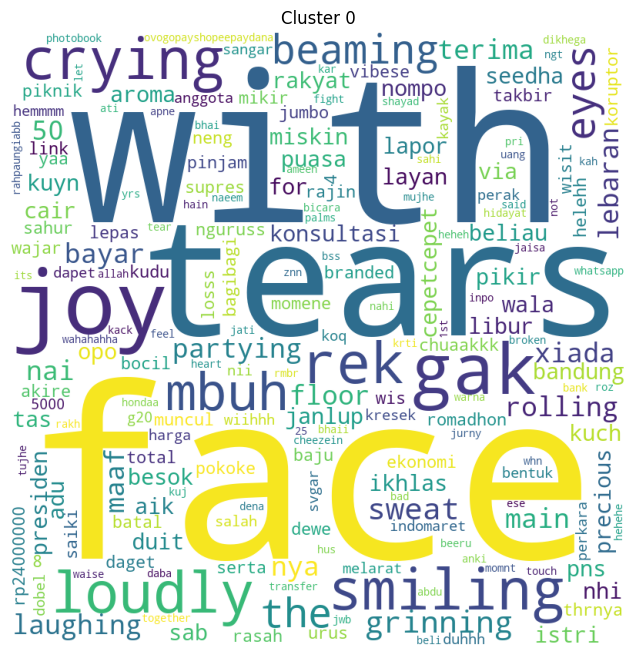

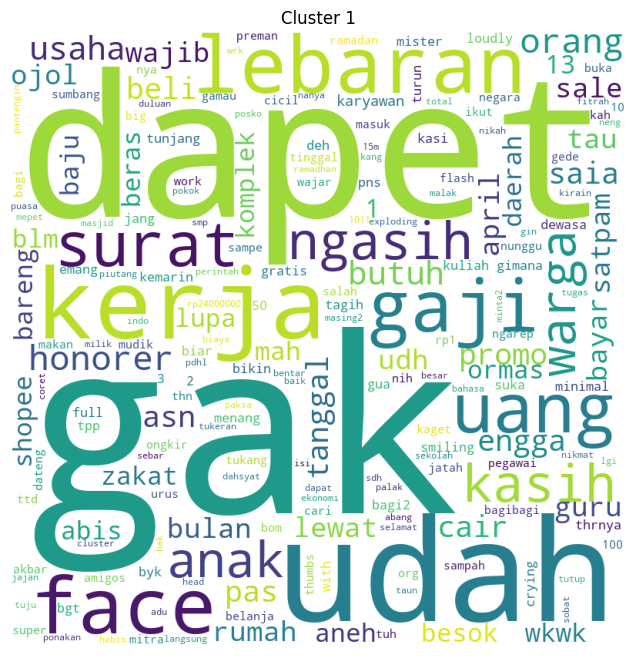

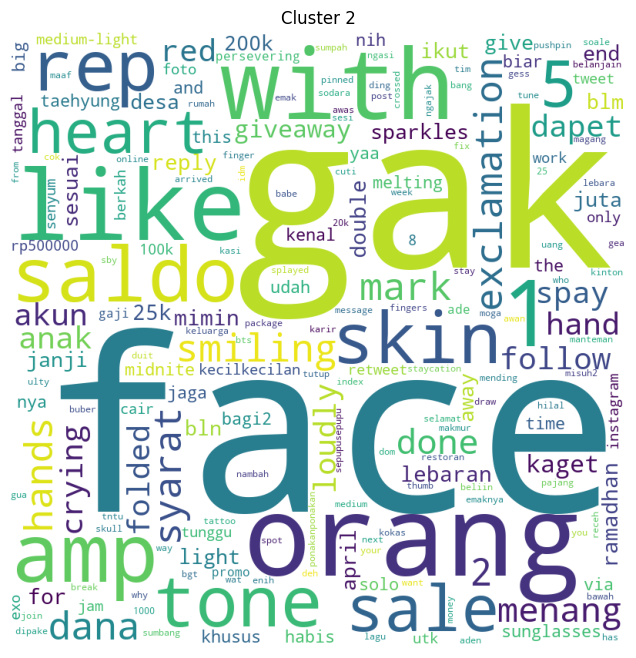

In [55]:
# Call the function with the dataframe containing the documents and the number of clusters you want to generate
create_wordclouds(df, 3) # Change "df" with your dataframe, and "5" with the number of clusters you want to generate.